In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Suppress expected warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def reduce_tokens_simple_truncation(text, tokenizer, max_length=512):
    """
    Simply truncate text to the maximum allowed token length.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text
    """
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

def reduce_tokens_smart_truncation(text, tokenizer, max_length=512):
    """
    Intelligently truncate text by keeping the beginning and end portions.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text with beginning and end portions
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Keep beginning and end portions (prioritize beginning slightly)
    beginning_length = max_length // 2 + 50  # Keep slightly more from beginning
    end_length = max_length - beginning_length - 1  # Reserve 1 for separator
    
    beginning_tokens = tokens[:beginning_length]
    end_tokens = tokens[-end_length:]
    
    # Combine with a separator token
    beginning_text = tokenizer.decode(beginning_tokens, skip_special_tokens=True)
    end_text = tokenizer.decode(end_tokens, skip_special_tokens=True)
    
    return f"{beginning_text} [...] {end_text}"

def reduce_tokens_extractive_summarization(text, tokenizer, max_length=512):
    """
    Reduce text length using extractive summarization techniques.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Summarized text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Import NLTK for sentence tokenization
    try:
        import nltk
        from nltk.tokenize import sent_tokenize
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
    except ImportError:
        # If NLTK is not available, fall back to smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    if len(sentences) <= 3:
        # Not enough sentences to summarize meaningfully, use smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Get sentence token lengths
    sentence_tokens = []
    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")["input_ids"][0]
        sentence_tokens.append((sentence, len(tokens)))
    
    # Calculate target ratio based on max length vs total length
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    reduction_ratio = max_length / len(tokens)
    
    # Always keep first and last sentences
    first_sentence, first_len = sentence_tokens[0]
    last_sentence, last_len = sentence_tokens[-1]
    
    remaining_length = max_length - first_len - last_len - 10  # Reserve some tokens for separators
    
    # If can't even fit first and last sentences, use smart truncation
    if remaining_length <= 0:
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Choose middle sentences based on importance (for now, just choose evenly distributed sentences)
    middle_sentences = sentence_tokens[1:-1]
    
    # Calculate how many middle sentences we can include
    middle_sentences_to_keep = []
    current_length = 0
    
    # Select sentences in a distributed manner
    if len(middle_sentences) > 0:
        # Fix: Add a check to prevent division by zero
        sentences_to_keep = int(reduction_ratio * len(middle_sentences))
        if sentences_to_keep <= 0:
            step = len(middle_sentences) + 1  # This will select only the first sentence if any
        else:
            step = max(1, len(middle_sentences) // sentences_to_keep)
            
        for i in range(0, len(middle_sentences), step):
            sentence, length = middle_sentences[i]
            if current_length + length <= remaining_length:
                middle_sentences_to_keep.append(sentence)
                current_length += length
            else:
                break
    
    # Combine sentences
    summarized_text = first_sentence
    
    if middle_sentences_to_keep:
        summarized_text += " " + " ".join(middle_sentences_to_keep)
    
    summarized_text += " " + last_sentence
    
    # Verify final length is within limit
    final_tokens = tokenizer(summarized_text, truncation=False, return_tensors="pt")["input_ids"][0]
    if len(final_tokens) > max_length:
        # Fall back to smart truncation if still too long
        return reduce_tokens_smart_truncation(summarized_text, tokenizer, max_length)
    
    return summarized_text

def reduce_tokens_hybrid(text, tokenizer, max_length=512):
    """
    Use a hybrid approach combining extractive summarization and smart truncation.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Processed text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # For very long documents, use extractive summarization first
    if len(tokens) > max_length * 2:
        summarized = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        summarized_tokens = tokenizer(summarized, truncation=False, return_tensors="pt")["input_ids"][0]
        
        # If still too long, apply smart truncation
        if len(summarized_tokens) > max_length:
            return reduce_tokens_smart_truncation(summarized, tokenizer, max_length)
        return summarized
    
    # For moderately long documents, use smart truncation directly
    return reduce_tokens_smart_truncation(text, tokenizer, max_length)

def process_with_token_reduction(texts, tokenizer, max_length=512, strategy="smart_truncation"):
    """
    Process a series of texts by applying token reduction where necessary.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        max_length (int): Maximum token length (default: 512)
        strategy (str): Token reduction strategy, one of:
            - "simple": Simple truncation at max_length
            - "smart_truncation": Keep beginning and end portions
            - "extractive_summarization": Use extractive summarization
            - "hybrid": Combine summarization and smart truncation
            
    Returns:
        pd.Series: Series with processed texts
    """
    processed_texts = []
    token_lengths_before = []
    token_lengths_after = []
    
    for text in tqdm(texts, desc=f"Applying token reduction ({strategy})"):
        # Calculate original token length
        tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_before.append(len(tokens))
        
        # Only process if longer than max_length
        if len(tokens) <= max_length:
            processed_texts.append(text)
            token_lengths_after.append(len(tokens))
            continue
        
        # Apply selected strategy
        if strategy == "simple":
            processed_text = reduce_tokens_simple_truncation(text, tokenizer, max_length)
        elif strategy == "smart_truncation":
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        elif strategy == "extractive_summarization":
            processed_text = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        elif strategy == "hybrid":
            processed_text = reduce_tokens_hybrid(text, tokenizer, max_length)
        else:
            # Default to smart truncation
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        
        processed_texts.append(processed_text)
        
        # Calculate new token length
        new_tokens = tokenizer(processed_text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_after.append(len(new_tokens))
    
    # Print statistics
    print(f"\nToken reduction statistics using {strategy} strategy:")
    print(f"  Before:")
    print(f"    Mean length: {np.mean(token_lengths_before):.2f}")
    print(f"    Median length: {np.median(token_lengths_before):.2f}")
    print(f"    Max length: {max(token_lengths_before)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_before if l > max_length)} ({sum(1 for l in token_lengths_before if l > max_length)/len(token_lengths_before)*100:.2f}%)")
    
    print(f"  After:")
    print(f"    Mean length: {np.mean(token_lengths_after):.2f}")
    print(f"    Median length: {np.median(token_lengths_after):.2f}")
    print(f"    Max length: {max(token_lengths_after)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_after if l > max_length)} ({sum(1 for l in token_lengths_after if l > max_length)/len(token_lengths_after)*100:.2f}%)")
    
    # Optional: Create histogram plot
    try:
        plt.figure(figsize=(10, 6))
        plt.hist([token_lengths_before, token_lengths_after], bins=30, 
                 label=['Before reduction', 'After reduction'], alpha=0.7)
        plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max length ({max_length})')
        plt.title(f'Token Length Distribution Before and After {strategy}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig(f'token_reduction_{strategy}.png')
        plt.close()
        print(f"  Distribution plot saved as token_reduction_{strategy}.png")
    except Exception as e:
        print(f"  Could not create distribution plot: {str(e)}")
    
    return pd.Series(processed_texts, index=texts.index)

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        # Define upper and lower bounds
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
        
        # Create mask for samples within bounds
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        # Update final mask with standard deviation condition
        final_mask = final_mask & std_mask
        
        std_removed = (~std_mask).sum()
        print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Removed {std_removed} samples by std dev filtering ({std_removed/original_size*100:.2f}% of data)")
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        # Create mask for minimum token threshold
        min_token_mask = token_lengths >= min_token_threshold
        
        # Track how many would be removed by this filter
        min_token_removed = (~min_token_mask).sum()
        
        # Track how many would be removed by this filter that weren't already filtered by std
        additional_removed = ((~min_token_mask) & final_mask).sum()
        
        # Update final mask with minimum token threshold condition
        final_mask = final_mask & min_token_mask
        
        print(f"Applied minimum token threshold of {min_token_threshold}")
        print(f"Removed {min_token_removed} samples below minimum token threshold ({min_token_removed/original_size*100:.2f}% of original data)")
        print(f"Of which {additional_removed} weren't already filtered by std deviation ({additional_removed/original_size*100:.2f}% of original data)")
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
    
class DeBERTaClassifier(nn.Module):
    """
    A classifier model based on DeBERTa for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # Note: DeBERTa has a different architecture than BERT/RoBERTa
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Unlike BERT, DeBERTa doesn't have a pooler, so we need to take the last hidden state
        # and either use the [CLS] token (first token) or do mean pooling
        # Here we'll use the [CLS] token (first token) representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(cls_output)
    
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
    

def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        filtered_labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(filtered_texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(filtered_texts)} ({len(filtered_texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
    print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
        # Remove samples with no labels
        filtered_labels = filtered_labels[empty_labels_mask]
        texts = texts[empty_labels_mask]
        print(f"Removed {empty_labels_count} samples with no labels")
    
    print(f"Samples remaining after label filtering: {len(filtered_labels)} ({len(filtered_labels)/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
    print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels

# Add hybrid feature selection function
def hybrid_feature_selection(texts, labels_encoded, mlb, top_k_filter=20, top_k_final=10, vectorizer=None, random_seed=42, wrapper_method='rf'):
    """
    Perform hybrid feature selection using both filter and wrapper methods.
    
    Args:
        texts (pd.Series): Series of text data
        labels_encoded (np.array): One-hot encoded labels
        mlb (MultiLabelBinarizer): Label encoder used for transforming labels
        top_k_filter (int): Number of labels to retain after filter stage
        top_k_final (int): Final number of labels to select
        vectorizer (object): Text vectorizer with fit_transform method. If None, uses simple word count
        random_seed (int): Random seed for reproducibility
        wrapper_method (str): Wrapper method to use ('rf' for Random Forest or 'lr' for Logistic Regression)
        
    Returns:
        tuple: Selected indices, selected label names, and feature importance scores
    """
    print(f"Starting hybrid feature selection to select {top_k_final} out of {labels_encoded.shape[1]} labels...")
    
    # If no vectorizer provided, create a simple one using sklearn's CountVectorizer
    if vectorizer is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(max_features=5000)
    
    # Transform texts to feature vectors
    print("Vectorizing text data...")
    X_vec = vectorizer.fit_transform(texts)
    
    # STEP 1: Filter Method - Use chi-square test and mutual information
    print("Applying filter methods...")
    
    # Store scores from multiple filter methods
    feature_scores = np.zeros(labels_encoded.shape[1])
    
    # Chi-square test for each label
    for i in range(labels_encoded.shape[1]):
        chi_scores = chi2(X_vec, labels_encoded[:, i])
        feature_scores[i] += chi_scores[0].mean()  # Add chi-square statistic
    
    # Mutual information for each label
    for i in range(labels_encoded.shape[1]):
        mi_score = mutual_info_classif(X_vec, labels_encoded[:, i], random_state=random_seed)
        feature_scores[i] += mi_score.mean() * 10  # Scale and add MI score
    
    # Get top-k features from filter methods
    filter_selected_indices = np.argsort(-feature_scores)[:top_k_filter]
    filter_selected_labels = np.array(mlb.classes_)[filter_selected_indices]
    
    print(f"Filter stage selected {len(filter_selected_indices)} labels")
    
    # STEP 2: Wrapper Method - Use specified model to evaluate feature subsets
    print(f"Applying wrapper method using {wrapper_method.upper()}...")
    
    # Initialize the appropriate model based on wrapper_method
    if wrapper_method.lower() == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
    elif wrapper_method.lower() == 'lr':
        model = LogisticRegression(random_state=random_seed, max_iter=1000)
    else:
        raise ValueError(f"Unsupported wrapper method: {wrapper_method}. Use 'rf' or 'lr'.")
    
    X_filtered = labels_encoded[:, filter_selected_indices]
    
    # For wrapper method, we'll create a matrix where each sample is label presence/absence
    # and the target is other labels - a proxy for how well each label predicts others
    importance_scores = np.zeros(len(filter_selected_indices))
    
    # For each label, train a model to predict it using the other labels
    for i in tqdm(range(len(filter_selected_indices)), desc="Wrapper evaluation"):
        # Current target label
        y = X_filtered[:, i]
        
        # Features (other labels)
        X_others = np.delete(X_filtered, i, axis=1)
        
        # Train model
        model.fit(X_others, y)
        
        # Score based on model performance
        accuracy = model.score(X_others, y)
        importance_scores[i] = accuracy
    
    # STEP 3: Combine scores to select final features
    final_scores = 0.6 * feature_scores[filter_selected_indices] + 0.4 * importance_scores
    final_selected_indices = filter_selected_indices[np.argsort(-final_scores)[:top_k_final]]
    final_selected_labels = np.array(mlb.classes_)[final_selected_indices]
    
    print(f"Final selection: {len(final_selected_labels)} labels")
    print("Selected labels:", final_selected_labels)
    
    return final_selected_indices, final_selected_labels, final_scores

def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Load the tokenizer for token length calculations
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Extract issue texts and labels
    texts = df[args.text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Determine token length filtering threshold based on args
    token_std_threshold = None
    if args.token_length_filter == '3std':
        token_std_threshold = 3.0
    elif args.token_length_filter == '2std':
        token_std_threshold = 2.0
    
    # Apply token length filtering first if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering...")
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # First filter by standard deviation, then by min threshold (in sequence)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe - keep original indices
        filtered_labels = labels[token_mask]
        filtered_df = df[token_mask]
        
        # Now reset indices for further processing
        texts = filtered_texts.reset_index(drop=True)
        labels = filtered_labels.reset_index(drop=True)
        filtered_df = filtered_df.reset_index(drop=True)
    else:
        filtered_df = df
    
    # Apply token reduction if requested (after outlier removal)
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy: {args.token_reduction_strategy}")
        texts = process_with_token_reduction(
            texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_df with the reduced texts
        filtered_df[args.text_column] = texts
    
    # Use prepare_data function to filter and prepare data, but skip token length filtering since we've done it
    texts, filtered_labels = prepare_data(
        filtered_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Set to None to skip the token filtering in prepare_data
        min_token_threshold=args.min_token_threshold
    )
    
    # Print final dataset statistics
    print("\n=== FINAL DATASET STATISTICS ===")
    print(f"Initial dataset size: {len(df)}")
    print(f"Final dataset size: {len(texts)}")
    print(f"Total samples removed: {len(df) - len(texts)} ({(len(df) - len(texts))/len(df)*100:.2f}% of original data)")
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\nLabel Distribution:')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\nLabel count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'initial_dataset_size': len(df),
        'final_dataset_size': len(texts),
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        }
    }
    
    # Calculate and add max token length to metadata
    if tokenizer is not None:
        token_lengths = calculate_token_lengths(texts, tokenizer)
        max_token_length = int(token_lengths.max())
        preprocessing_metadata['token_stats'] = {
            'max_token_length': max_token_length,
            'mean_token_length': float(token_lengths.mean()),
            'median_token_length': float(token_lengths.median())
        }
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Maximum token length: {max_token_length}")
        print(f"Mean token length: {token_lengths.mean():.2f}")
        print(f"Median token length: {token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # print hybrid feature selection args
    print(f"Feature selection enabled: {args.feature_selection}")
    if args.feature_selection:
        print(f"Filter top-k: {args.filter_k}, Final top-k: {args.final_k}")
        print(f"Wrapper method: {args.wrapper_method.upper()}")
    else : 
        print("Feature selection disabled")
    # Perform hybrid feature selection if enabled
    if args.feature_selection:
        print(f"\nPerforming hybrid feature selection...")
        
        # Create appropriate vectorizer based on argument
        if args.vectorizer == 'tfidf':
            from sklearn.feature_extraction.text import TfidfVectorizer
            vectorizer = TfidfVectorizer(max_features=5000)
            print("Using TF-IDF vectorizer for feature selection")
        else:  # default to count
            from sklearn.feature_extraction.text import CountVectorizer
            vectorizer = CountVectorizer(max_features=5000)
            print("Using Count vectorizer for feature selection")
        
        selected_indices, selected_labels, feature_scores = hybrid_feature_selection(
            texts, labels_encoded, mlb, 
            top_k_filter=args.filter_k,
            top_k_final=args.final_k,
            vectorizer=vectorizer,
            random_seed=42,
            wrapper_method=args.wrapper_method
        )
        
        # Filter labels_encoded to keep only selected labels
        labels_encoded = labels_encoded[:, selected_indices]
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selected_labels': selected_labels.tolist(),
                'feature_scores': feature_scores.tolist(),
                'selected_indices': selected_indices.tolist(),
                'vectorizer_type': args.vectorizer,
                'wrapper_method': args.wrapper_method
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print("Feature selection disabled, using all labels")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer, max_length=args.max_length)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = DeBERTaClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

2025-04-11 10:22:45.964592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744366966.217276      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744366966.281976      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]


Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:03<00:00, 380.57it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples by std dev filtering (1.67% of data)
Total removed: 21 samples (1.67% of original data)
Remaining: 1237 samples (98.33% of original data)

Token length statistics after all filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1222 (98.79% of data)

St

Calculating token lengths: 100%|██████████| 1156/1156 [00:02<00:00, 518.71it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1725
Mean token length: 325.18
Median token length: 231.50
Encoding labels...
Label density: 0.0672
Average labels per sample: 1.34
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 924, Validation samples: 232
Loading tokenizer...
Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20



Training: 100%|██████████| 29/29 [00:39<00:00,  1.35s/it]


Train Loss: 0.5276, Train Accuracy (Exact Match): 0.0130
Val Loss: 0.2237
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


Train Loss: 0.2143, Train Accuracy (Exact Match): 0.0022
Val Loss: 0.1973
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:39<00:00,  1.35s/it]


Train Loss: 0.2023, Train Accuracy (Exact Match): 0.0054
Val Loss: 0.1915
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Train Loss: 0.1973, Train Accuracy (Exact Match): 0.0162
Val Loss: 0.1851
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.1885, Train Accuracy (Exact Match): 0.0368
Val Loss: 0.1759
Val Accuracy (Exact Match): 0.0431
Val Accuracy (Partial Match): 0.0445
Val Accuracy (Jaccard): 0.0445
Val Precision: 0.0474, Val Recall: 0.0445, Val F1: 0.0453
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.1634, Train Accuracy (Exact Match): 0.2154
Val Loss: 0.1532
Val Accuracy (Exact Match): 0.2888
Val Accuracy (Partial Match): 0.3990
Val Accuracy (Jaccard): 0.3659
Val Precision: 0.4138, Val Recall: 0.3990, Val F1: 0.3923
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.1331, Train Accuracy (Exact Match): 0.3961
Val Loss: 0.1364
Val Accuracy (Exact Match): 0.3621
Val Accuracy (Partial Match): 0.4708
Val Accuracy (Jaccard): 0.4381
Val Precision: 0.4845, Val Recall: 0.4708, Val F1: 0.4641
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.1083, Train Accuracy (Exact Match): 0.5455
Val Loss: 0.1228
Val Accuracy (Exact Match): 0.4526
Val Accuracy (Partial Match): 0.5838
Val Accuracy (Jaccard): 0.5402
Val Precision: 0.5815, Val Recall: 0.5838, Val F1: 0.5696
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0924, Train Accuracy (Exact Match): 0.6342
Val Loss: 0.1177
Val Accuracy (Exact Match): 0.5431
Val Accuracy (Partial Match): 0.6657
Val Accuracy (Jaccard): 0.6272
Val Precision: 0.6698, Val Recall: 0.6657, Val F1: 0.6551
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0808, Train Accuracy (Exact Match): 0.6883
Val Loss: 0.1112
Val Accuracy (Exact Match): 0.5560
Val Accuracy (Partial Match): 0.6991
Val Accuracy (Jaccard): 0.6528
Val Precision: 0.7004, Val Recall: 0.6991, Val F1: 0.6852
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0741, Train Accuracy (Exact Match): 0.7100
Val Loss: 0.1107
Val Accuracy (Exact Match): 0.5690
Val Accuracy (Partial Match): 0.7217
Val Accuracy (Jaccard): 0.6695
Val Precision: 0.7151, Val Recall: 0.7217, Val F1: 0.7033
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Train Loss: 0.0672, Train Accuracy (Exact Match): 0.7294
Val Loss: 0.1101
Val Accuracy (Exact Match): 0.5603
Val Accuracy (Partial Match): 0.7626
Val Accuracy (Jaccard): 0.6853
Val Precision: 0.7302, Val Recall: 0.7626, Val F1: 0.7270
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0621, Train Accuracy (Exact Match): 0.7435
Val Loss: 0.1077
Val Accuracy (Exact Match): 0.5733
Val Accuracy (Partial Match): 0.7616
Val Accuracy (Jaccard): 0.6967
Val Precision: 0.7537, Val Recall: 0.7616, Val F1: 0.7371
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0576, Train Accuracy (Exact Match): 0.7652
Val Loss: 0.1136
Val Accuracy (Exact Match): 0.5776
Val Accuracy (Partial Match): 0.7713
Val Accuracy (Jaccard): 0.6976
Val Precision: 0.7409, Val Recall: 0.7713, Val F1: 0.7377
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0552, Train Accuracy (Exact Match): 0.7673
Val Loss: 0.1101
Val Accuracy (Exact Match): 0.5517
Val Accuracy (Partial Match): 0.7713
Val Accuracy (Jaccard): 0.6904
Val Precision: 0.7453, Val Recall: 0.7713, Val F1: 0.7356

Epoch 16/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Train Loss: 0.0512, Train Accuracy (Exact Match): 0.7879
Val Loss: 0.1059
Val Accuracy (Exact Match): 0.5733
Val Accuracy (Partial Match): 0.7648
Val Accuracy (Jaccard): 0.6976
Val Precision: 0.7517, Val Recall: 0.7648, Val F1: 0.7385
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Train Loss: 0.0481, Train Accuracy (Exact Match): 0.8063
Val Loss: 0.1055
Val Accuracy (Exact Match): 0.5991
Val Accuracy (Partial Match): 0.7820
Val Accuracy (Jaccard): 0.7170
Val Precision: 0.7668, Val Recall: 0.7820, Val F1: 0.7557
Saved new best model to ./results/run_20250411_102258_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Early stopping triggered
Train Loss: 0.0457, Train Accuracy (Exact Match): 0.8171
Val Loss: 0.1069
Val Accuracy (Exact Match): 0.5819
Val Accuracy (Partial Match): 0.7820
Val Accuracy (Jaccard): 0.7091
Val Precision: 0.7603, Val Recall: 0.7820, Val F1: 0.7507
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_18/3177817570.py:1302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5991
Partial Match Accuracy: 0.7820
Jaccard Similarity: 0.7170
Precision: 0.7668
Recall: 0.7820
F1 Score: 0.7557

Training completed! Results saved to ./results/run_20250411_102258_all_text_0.5


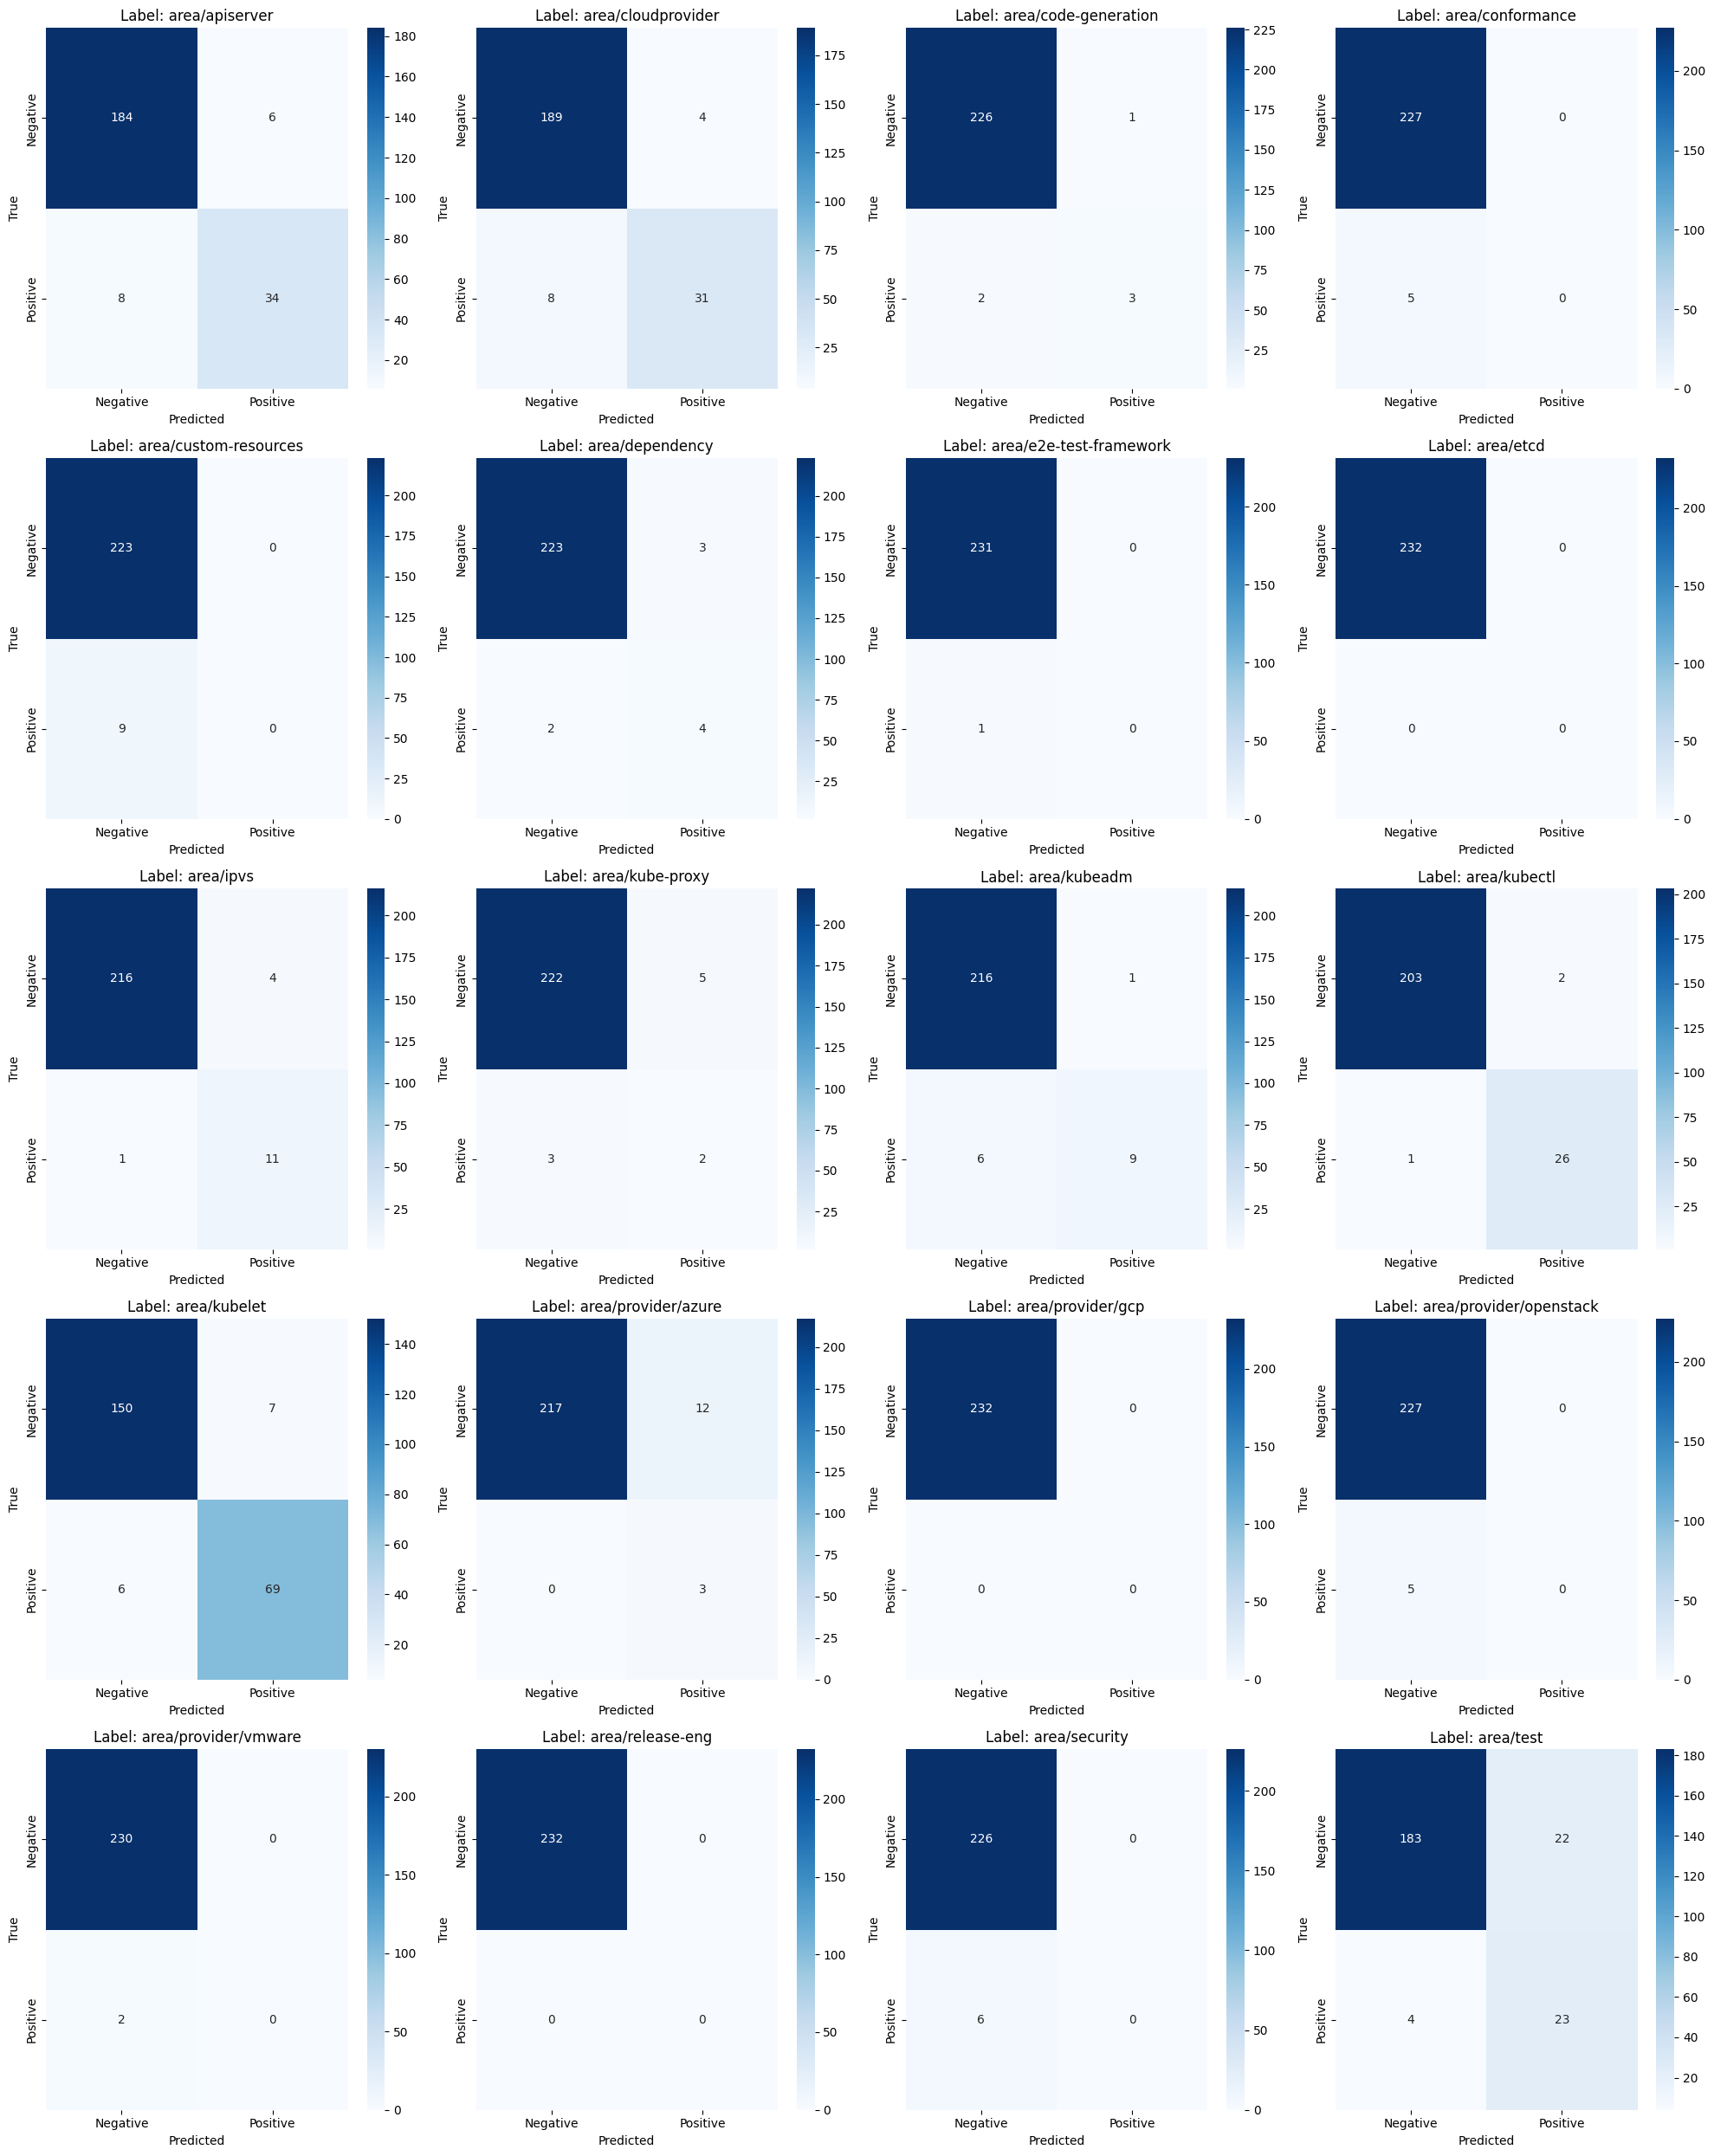

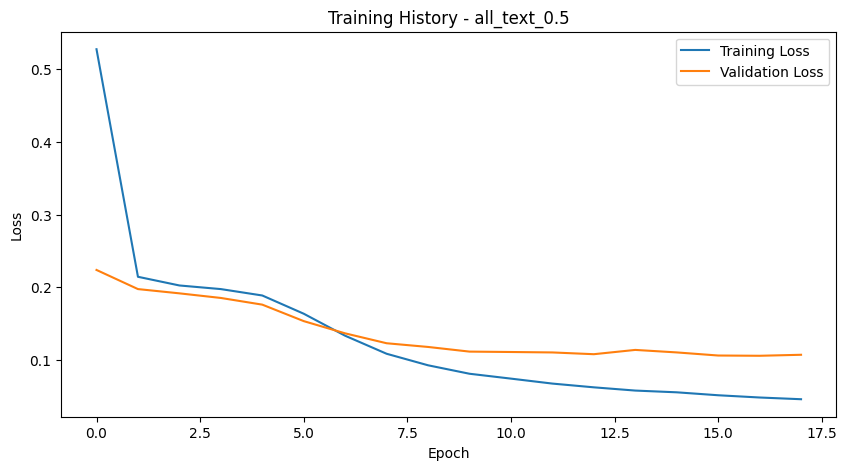

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:03<00:00, 384.49it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples by std dev filtering (1.67% of data)
Total removed: 21 samples (1.67% of original data)
Remaining: 1237 samples (98.33% of original data)

Token length statistics after all filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1222 (98.79% of data)

St

Calculating token lengths: 100%|██████████| 1136/1136 [00:02<00:00, 523.76it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1693
Mean token length: 315.60
Median token length: 229.50
Encoding labels...
Label density: 0.0640
Average labels per sample: 1.28
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 908, Validation samples: 228
Loading tokenizer...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.5028, Train Accuracy (Exact Match): 0.0231
Val Loss: 0.2163
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.2053, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.1870
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.1933, Train Accuracy (Exact Match): 0.0066
Val Loss: 0.1811
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.1882, Train Accuracy (Exact Match): 0.0055
Val Loss: 0.1802
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.1777, Train Accuracy (Exact Match): 0.0396
Val Loss: 0.1659
Val Accuracy (Exact Match): 0.1535
Val Accuracy (Partial Match): 0.1615
Val Accuracy (Jaccard): 0.1615
Val Precision: 0.1711, Val Recall: 0.1615, Val F1: 0.1645
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.1575, Train Accuracy (Exact Match): 0.2412
Val Loss: 0.1440
Val Accuracy (Exact Match): 0.2500
Val Accuracy (Partial Match): 0.3260
Val Accuracy (Jaccard): 0.2990
Val Precision: 0.3268, Val Recall: 0.3260, Val F1: 0.3165
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.1305, Train Accuracy (Exact Match): 0.3932
Val Loss: 0.1262
Val Accuracy (Exact Match): 0.3728
Val Accuracy (Partial Match): 0.4905
Val Accuracy (Jaccard): 0.4510
Val Precision: 0.5000, Val Recall: 0.4905, Val F1: 0.4803
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.1094, Train Accuracy (Exact Match): 0.5341
Val Loss: 0.1133
Val Accuracy (Exact Match): 0.4868
Val Accuracy (Partial Match): 0.6089
Val Accuracy (Jaccard): 0.5694
Val Precision: 0.6140, Val Recall: 0.6089, Val F1: 0.5982
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.0910, Train Accuracy (Exact Match): 0.6267
Val Loss: 0.1074
Val Accuracy (Exact Match): 0.5614
Val Accuracy (Partial Match): 0.6985
Val Accuracy (Jaccard): 0.6531
Val Precision: 0.6974, Val Recall: 0.6985, Val F1: 0.6839
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.0783, Train Accuracy (Exact Match): 0.6993
Val Loss: 0.1043
Val Accuracy (Exact Match): 0.5526
Val Accuracy (Partial Match): 0.7116
Val Accuracy (Jaccard): 0.6586
Val Precision: 0.7072, Val Recall: 0.7116, Val F1: 0.6935
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.0712, Train Accuracy (Exact Match): 0.7280
Val Loss: 0.1038
Val Accuracy (Exact Match): 0.5482
Val Accuracy (Partial Match): 0.7511
Val Accuracy (Jaccard): 0.6776
Val Precision: 0.7292, Val Recall: 0.7511, Val F1: 0.7205
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Train Loss: 0.0654, Train Accuracy (Exact Match): 0.7489
Val Loss: 0.1001
Val Accuracy (Exact Match): 0.5658
Val Accuracy (Partial Match): 0.7489
Val Accuracy (Jaccard): 0.6843
Val Precision: 0.7346, Val Recall: 0.7489, Val F1: 0.7237
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.0606, Train Accuracy (Exact Match): 0.7478
Val Loss: 0.0994
Val Accuracy (Exact Match): 0.5614
Val Accuracy (Partial Match): 0.7643
Val Accuracy (Jaccard): 0.6894
Val Precision: 0.7390, Val Recall: 0.7643, Val F1: 0.7318
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.48s/it]


Train Loss: 0.0569, Train Accuracy (Exact Match): 0.7621
Val Loss: 0.0977
Val Accuracy (Exact Match): 0.5921
Val Accuracy (Partial Match): 0.7701
Val Accuracy (Jaccard): 0.7040
Val Precision: 0.7478, Val Recall: 0.7701, Val F1: 0.7414
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Train Loss: 0.0527, Train Accuracy (Exact Match): 0.7874
Val Loss: 0.1000
Val Accuracy (Exact Match): 0.5658
Val Accuracy (Partial Match): 0.7643
Val Accuracy (Jaccard): 0.6887
Val Precision: 0.7368, Val Recall: 0.7643, Val F1: 0.7299

Epoch 16/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Train Loss: 0.0493, Train Accuracy (Exact Match): 0.8029
Val Loss: 0.0961
Val Accuracy (Exact Match): 0.5877
Val Accuracy (Partial Match): 0.7621
Val Accuracy (Jaccard): 0.7004
Val Precision: 0.7522, Val Recall: 0.7621, Val F1: 0.7379

Epoch 17/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Train Loss: 0.0477, Train Accuracy (Exact Match): 0.7919
Val Loss: 0.0949
Val Accuracy (Exact Match): 0.5921
Val Accuracy (Partial Match): 0.7723
Val Accuracy (Jaccard): 0.7084
Val Precision: 0.7588, Val Recall: 0.7723, Val F1: 0.7465
Saved new best model to ./results/run_20250411_103816_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Early stopping triggered
Train Loss: 0.0436, Train Accuracy (Exact Match): 0.8183
Val Loss: 0.1005
Val Accuracy (Exact Match): 0.5877
Val Accuracy (Partial Match): 0.7811
Val Accuracy (Jaccard): 0.7062
Val Precision: 0.7478, Val Recall: 0.7811, Val F1: 0.7465
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_18/3177817570.py:1302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5921
Partial Match Accuracy: 0.7723
Jaccard Similarity: 0.7084
Precision: 0.7588
Recall: 0.7723
F1 Score: 0.7465

Training completed! Results saved to ./results/run_20250411_103816_all_text_0.5


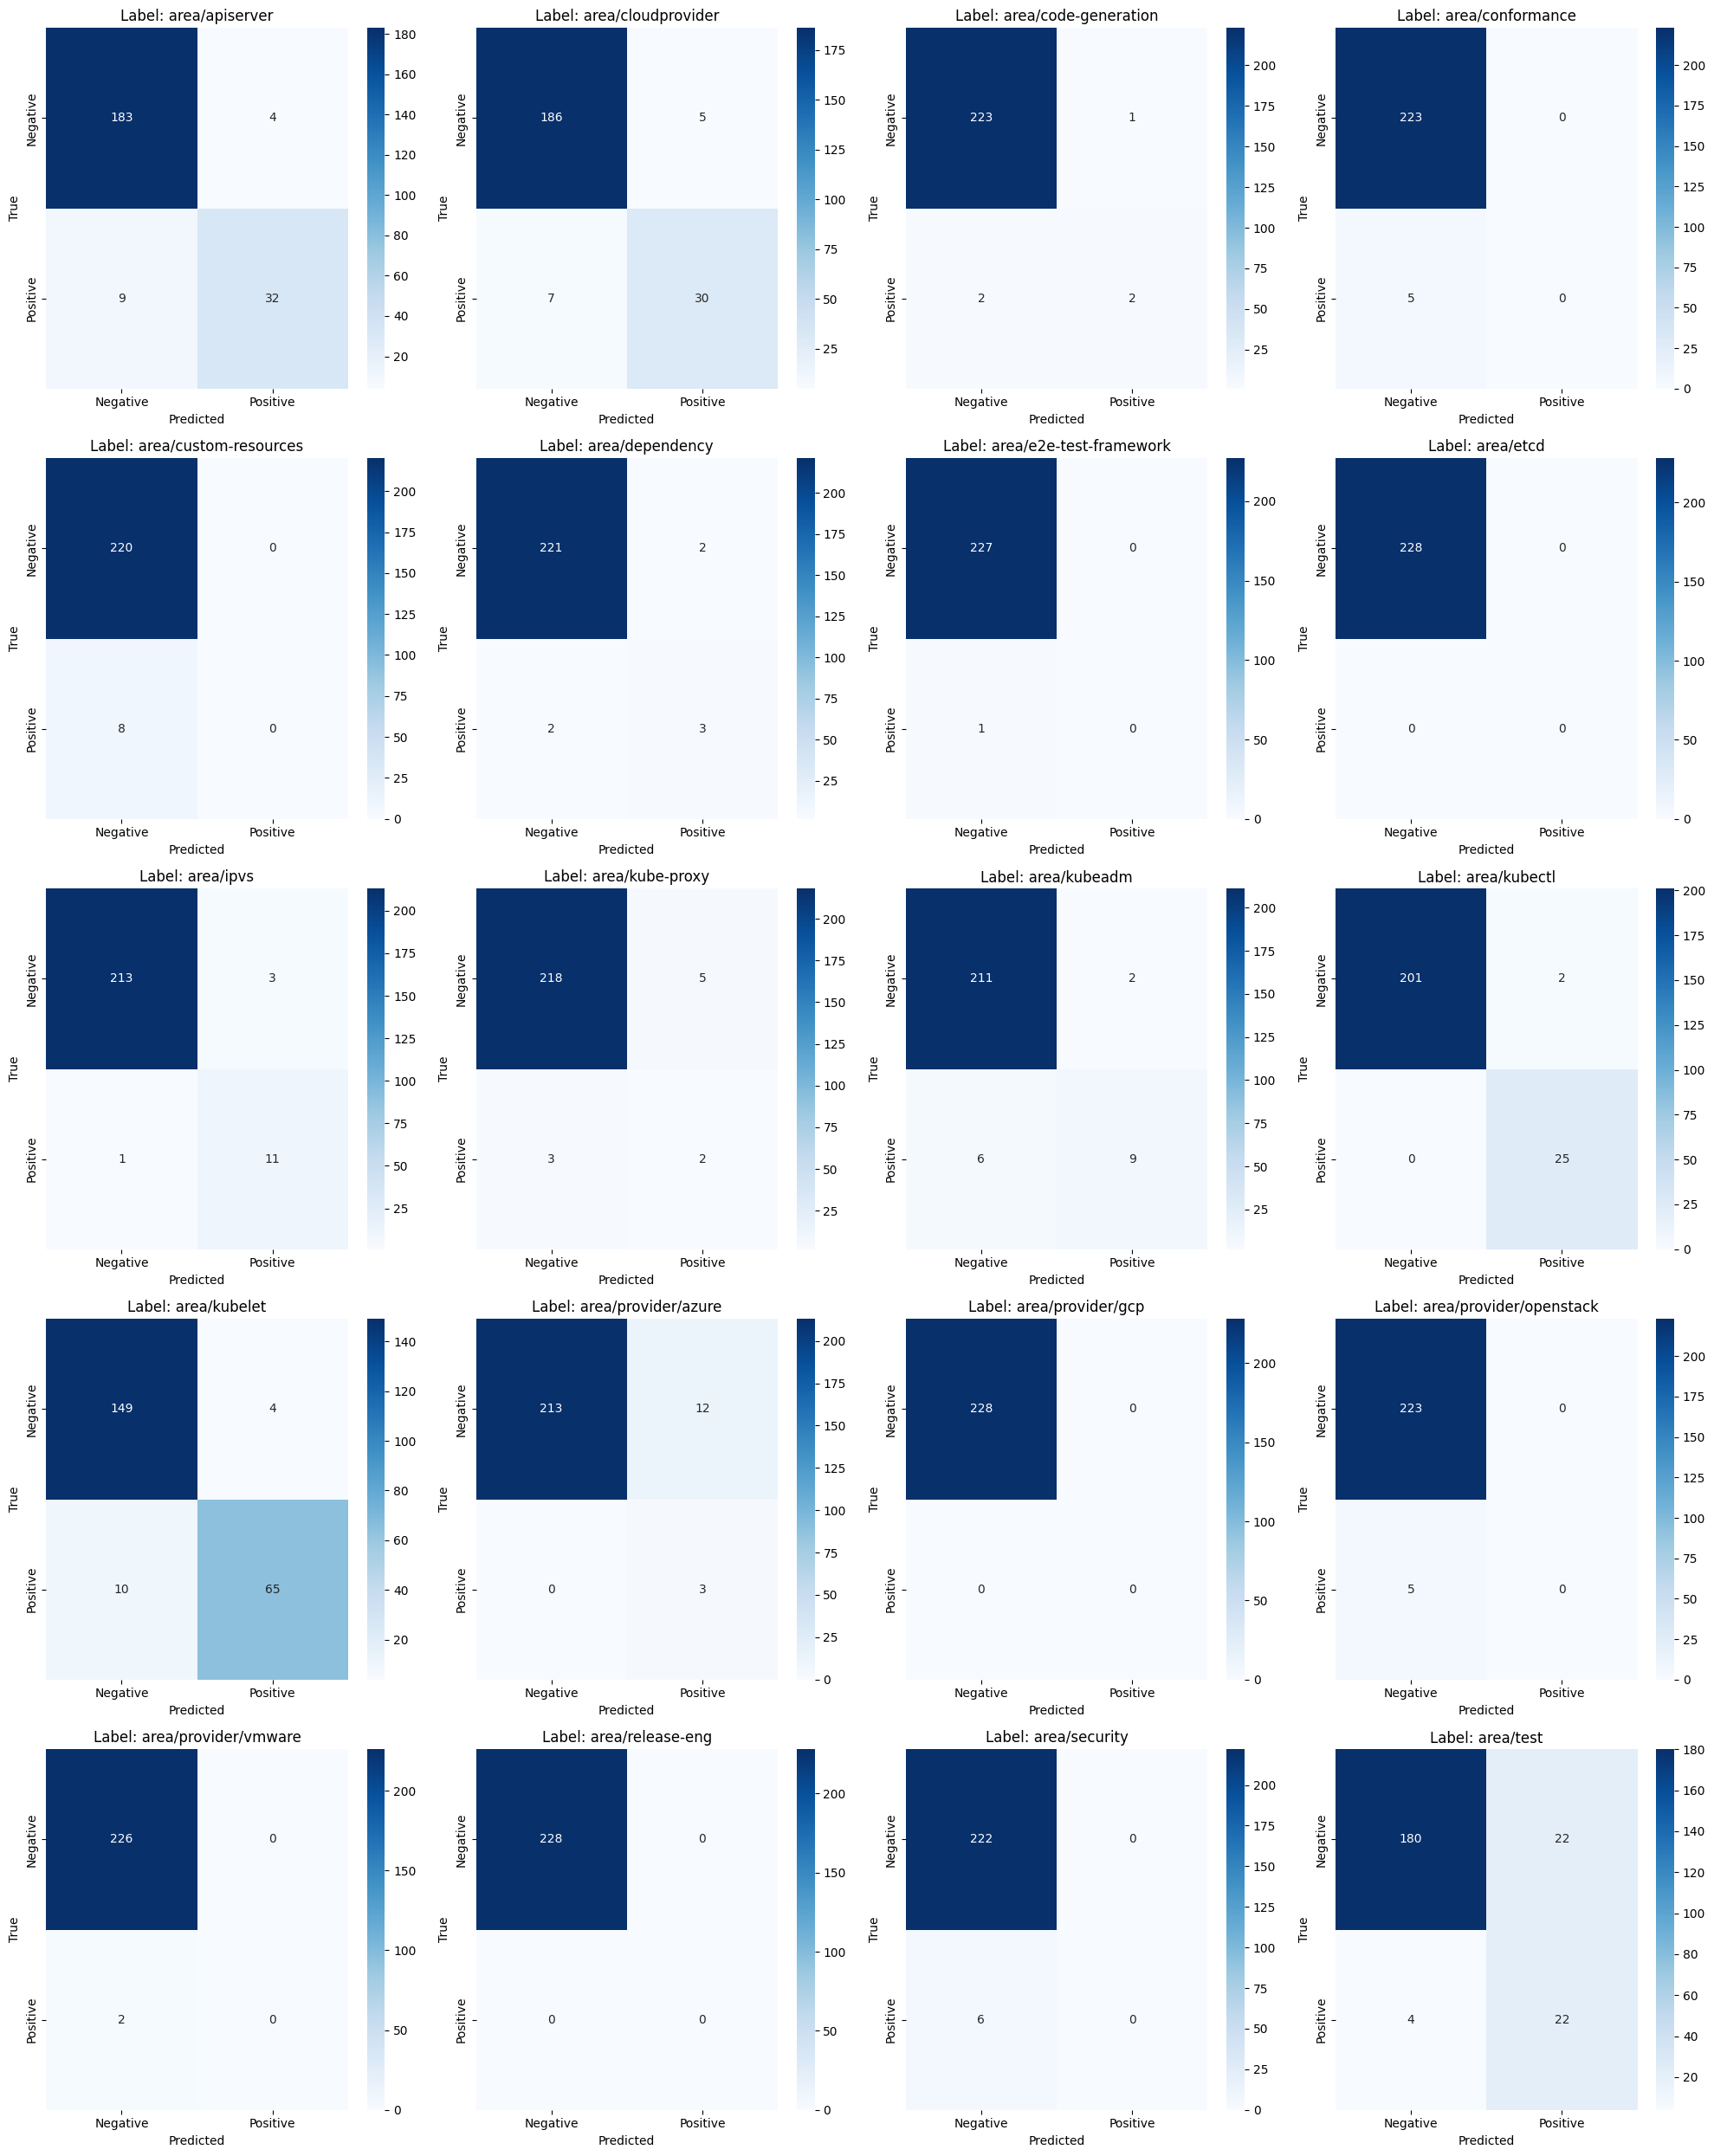

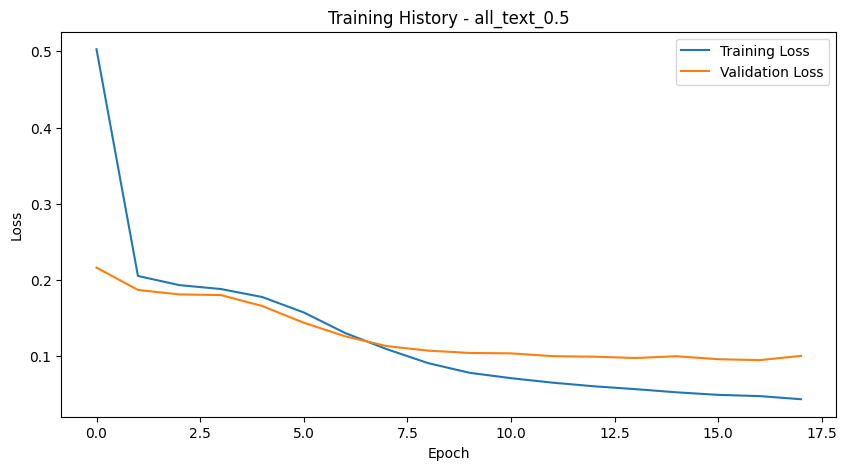

In [3]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=4,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:03<00:00, 390.04it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples by std dev filtering (1.67% of data)
Total removed: 21 samples (1.67% of original data)
Remaining: 1237 samples (98.33% of original data)

Token length statistics after all filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1222 (98.79% of data)

St

Calculating token lengths: 100%|██████████| 1122/1122 [00:02<00:00, 535.39it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1693
Mean token length: 310.33
Median token length: 226.00
Encoding labels...
Label density: 0.0656
Average labels per sample: 1.25
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 897, Validation samples: 225
Loading tokenizer...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 29/29 [00:43<00:00,  1.51s/it]


Train Loss: 0.5425, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.2223
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Train Loss: 0.2090, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.1937
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Train Loss: 0.1945, Train Accuracy (Exact Match): 0.0033
Val Loss: 0.1906
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Train Loss: 0.1899, Train Accuracy (Exact Match): 0.0089
Val Loss: 0.1847
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Train Loss: 0.1921, Train Accuracy (Exact Match): 0.0245
Val Loss: 0.1830
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.1774, Train Accuracy (Exact Match): 0.0446
Val Loss: 0.1720
Val Accuracy (Exact Match): 0.0533
Val Accuracy (Partial Match): 0.0756
Val Accuracy (Jaccard): 0.0667
Val Precision: 0.0711, Val Recall: 0.0756, Val F1: 0.0711
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.1573, Train Accuracy (Exact Match): 0.1817
Val Loss: 0.1467
Val Accuracy (Exact Match): 0.2800
Val Accuracy (Partial Match): 0.3459
Val Accuracy (Jaccard): 0.3237
Val Precision: 0.3511, Val Recall: 0.3459, Val F1: 0.3393
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.1304, Train Accuracy (Exact Match): 0.3802
Val Loss: 0.1307
Val Accuracy (Exact Match): 0.3422
Val Accuracy (Partial Match): 0.4541
Val Accuracy (Jaccard): 0.4193
Val Precision: 0.4689, Val Recall: 0.4541, Val F1: 0.4465
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Train Loss: 0.1067, Train Accuracy (Exact Match): 0.5262
Val Loss: 0.1183
Val Accuracy (Exact Match): 0.4400
Val Accuracy (Partial Match): 0.5667
Val Accuracy (Jaccard): 0.5244
Val Precision: 0.5711, Val Recall: 0.5667, Val F1: 0.5545
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.0886, Train Accuracy (Exact Match): 0.6388
Val Loss: 0.1138
Val Accuracy (Exact Match): 0.4978
Val Accuracy (Partial Match): 0.6281
Val Accuracy (Jaccard): 0.5844
Val Precision: 0.6289, Val Recall: 0.6281, Val F1: 0.6144
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Train Loss: 0.0776, Train Accuracy (Exact Match): 0.6901
Val Loss: 0.1028
Val Accuracy (Exact Match): 0.5378
Val Accuracy (Partial Match): 0.6881
Val Accuracy (Jaccard): 0.6393
Val Precision: 0.6933, Val Recall: 0.6881, Val F1: 0.6729
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Train Loss: 0.0727, Train Accuracy (Exact Match): 0.7068
Val Loss: 0.1077
Val Accuracy (Exact Match): 0.5422
Val Accuracy (Partial Match): 0.7385
Val Accuracy (Jaccard): 0.6644
Val Precision: 0.7111, Val Recall: 0.7385, Val F1: 0.7053
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


Train Loss: 0.0679, Train Accuracy (Exact Match): 0.7202
Val Loss: 0.1046
Val Accuracy (Exact Match): 0.5333
Val Accuracy (Partial Match): 0.7222
Val Accuracy (Jaccard): 0.6519
Val Precision: 0.7000, Val Recall: 0.7222, Val F1: 0.6914

Epoch 14/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.0638, Train Accuracy (Exact Match): 0.7391
Val Loss: 0.1007
Val Accuracy (Exact Match): 0.5600
Val Accuracy (Partial Match): 0.7385
Val Accuracy (Jaccard): 0.6763
Val Precision: 0.7289, Val Recall: 0.7385, Val F1: 0.7142
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


Train Loss: 0.0671, Train Accuracy (Exact Match): 0.7458
Val Loss: 0.1028
Val Accuracy (Exact Match): 0.5733
Val Accuracy (Partial Match): 0.7348
Val Accuracy (Jaccard): 0.6785
Val Precision: 0.7289, Val Recall: 0.7348, Val F1: 0.7136

Epoch 16/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.0587, Train Accuracy (Exact Match): 0.7514
Val Loss: 0.1107
Val Accuracy (Exact Match): 0.5644
Val Accuracy (Partial Match): 0.7578
Val Accuracy (Jaccard): 0.6807
Val Precision: 0.7244, Val Recall: 0.7578, Val F1: 0.7212
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Train Loss: 0.0533, Train Accuracy (Exact Match): 0.7748
Val Loss: 0.1038
Val Accuracy (Exact Match): 0.5689
Val Accuracy (Partial Match): 0.7393
Val Accuracy (Jaccard): 0.6770
Val Precision: 0.7244, Val Recall: 0.7393, Val F1: 0.7136

Epoch 18/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.0492, Train Accuracy (Exact Match): 0.7793
Val Loss: 0.1062
Val Accuracy (Exact Match): 0.5689
Val Accuracy (Partial Match): 0.7526
Val Accuracy (Jaccard): 0.6807
Val Precision: 0.7222, Val Recall: 0.7526, Val F1: 0.7188

Epoch 19/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.0456, Train Accuracy (Exact Match): 0.8038
Val Loss: 0.1059
Val Accuracy (Exact Match): 0.5689
Val Accuracy (Partial Match): 0.7593
Val Accuracy (Jaccard): 0.6874
Val Precision: 0.7356, Val Recall: 0.7593, Val F1: 0.7270
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Epoch 20/20


Training: 100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


Train Loss: 0.0431, Train Accuracy (Exact Match): 0.8138
Val Loss: 0.1033
Val Accuracy (Exact Match): 0.5867
Val Accuracy (Partial Match): 0.7681
Val Accuracy (Jaccard): 0.6985
Val Precision: 0.7422, Val Recall: 0.7681, Val F1: 0.7359
Saved new best model to ./results/run_20250411_105342_all_text_0.5/best_model_all_text_0.5.pt

Loading best model for final evaluation...


/tmp/ipykernel_18/3177817570.py:1302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5867
Partial Match Accuracy: 0.7681
Jaccard Similarity: 0.6985
Precision: 0.7422
Recall: 0.7681
F1 Score: 0.7359

Training completed! Results saved to ./results/run_20250411_105342_all_text_0.5


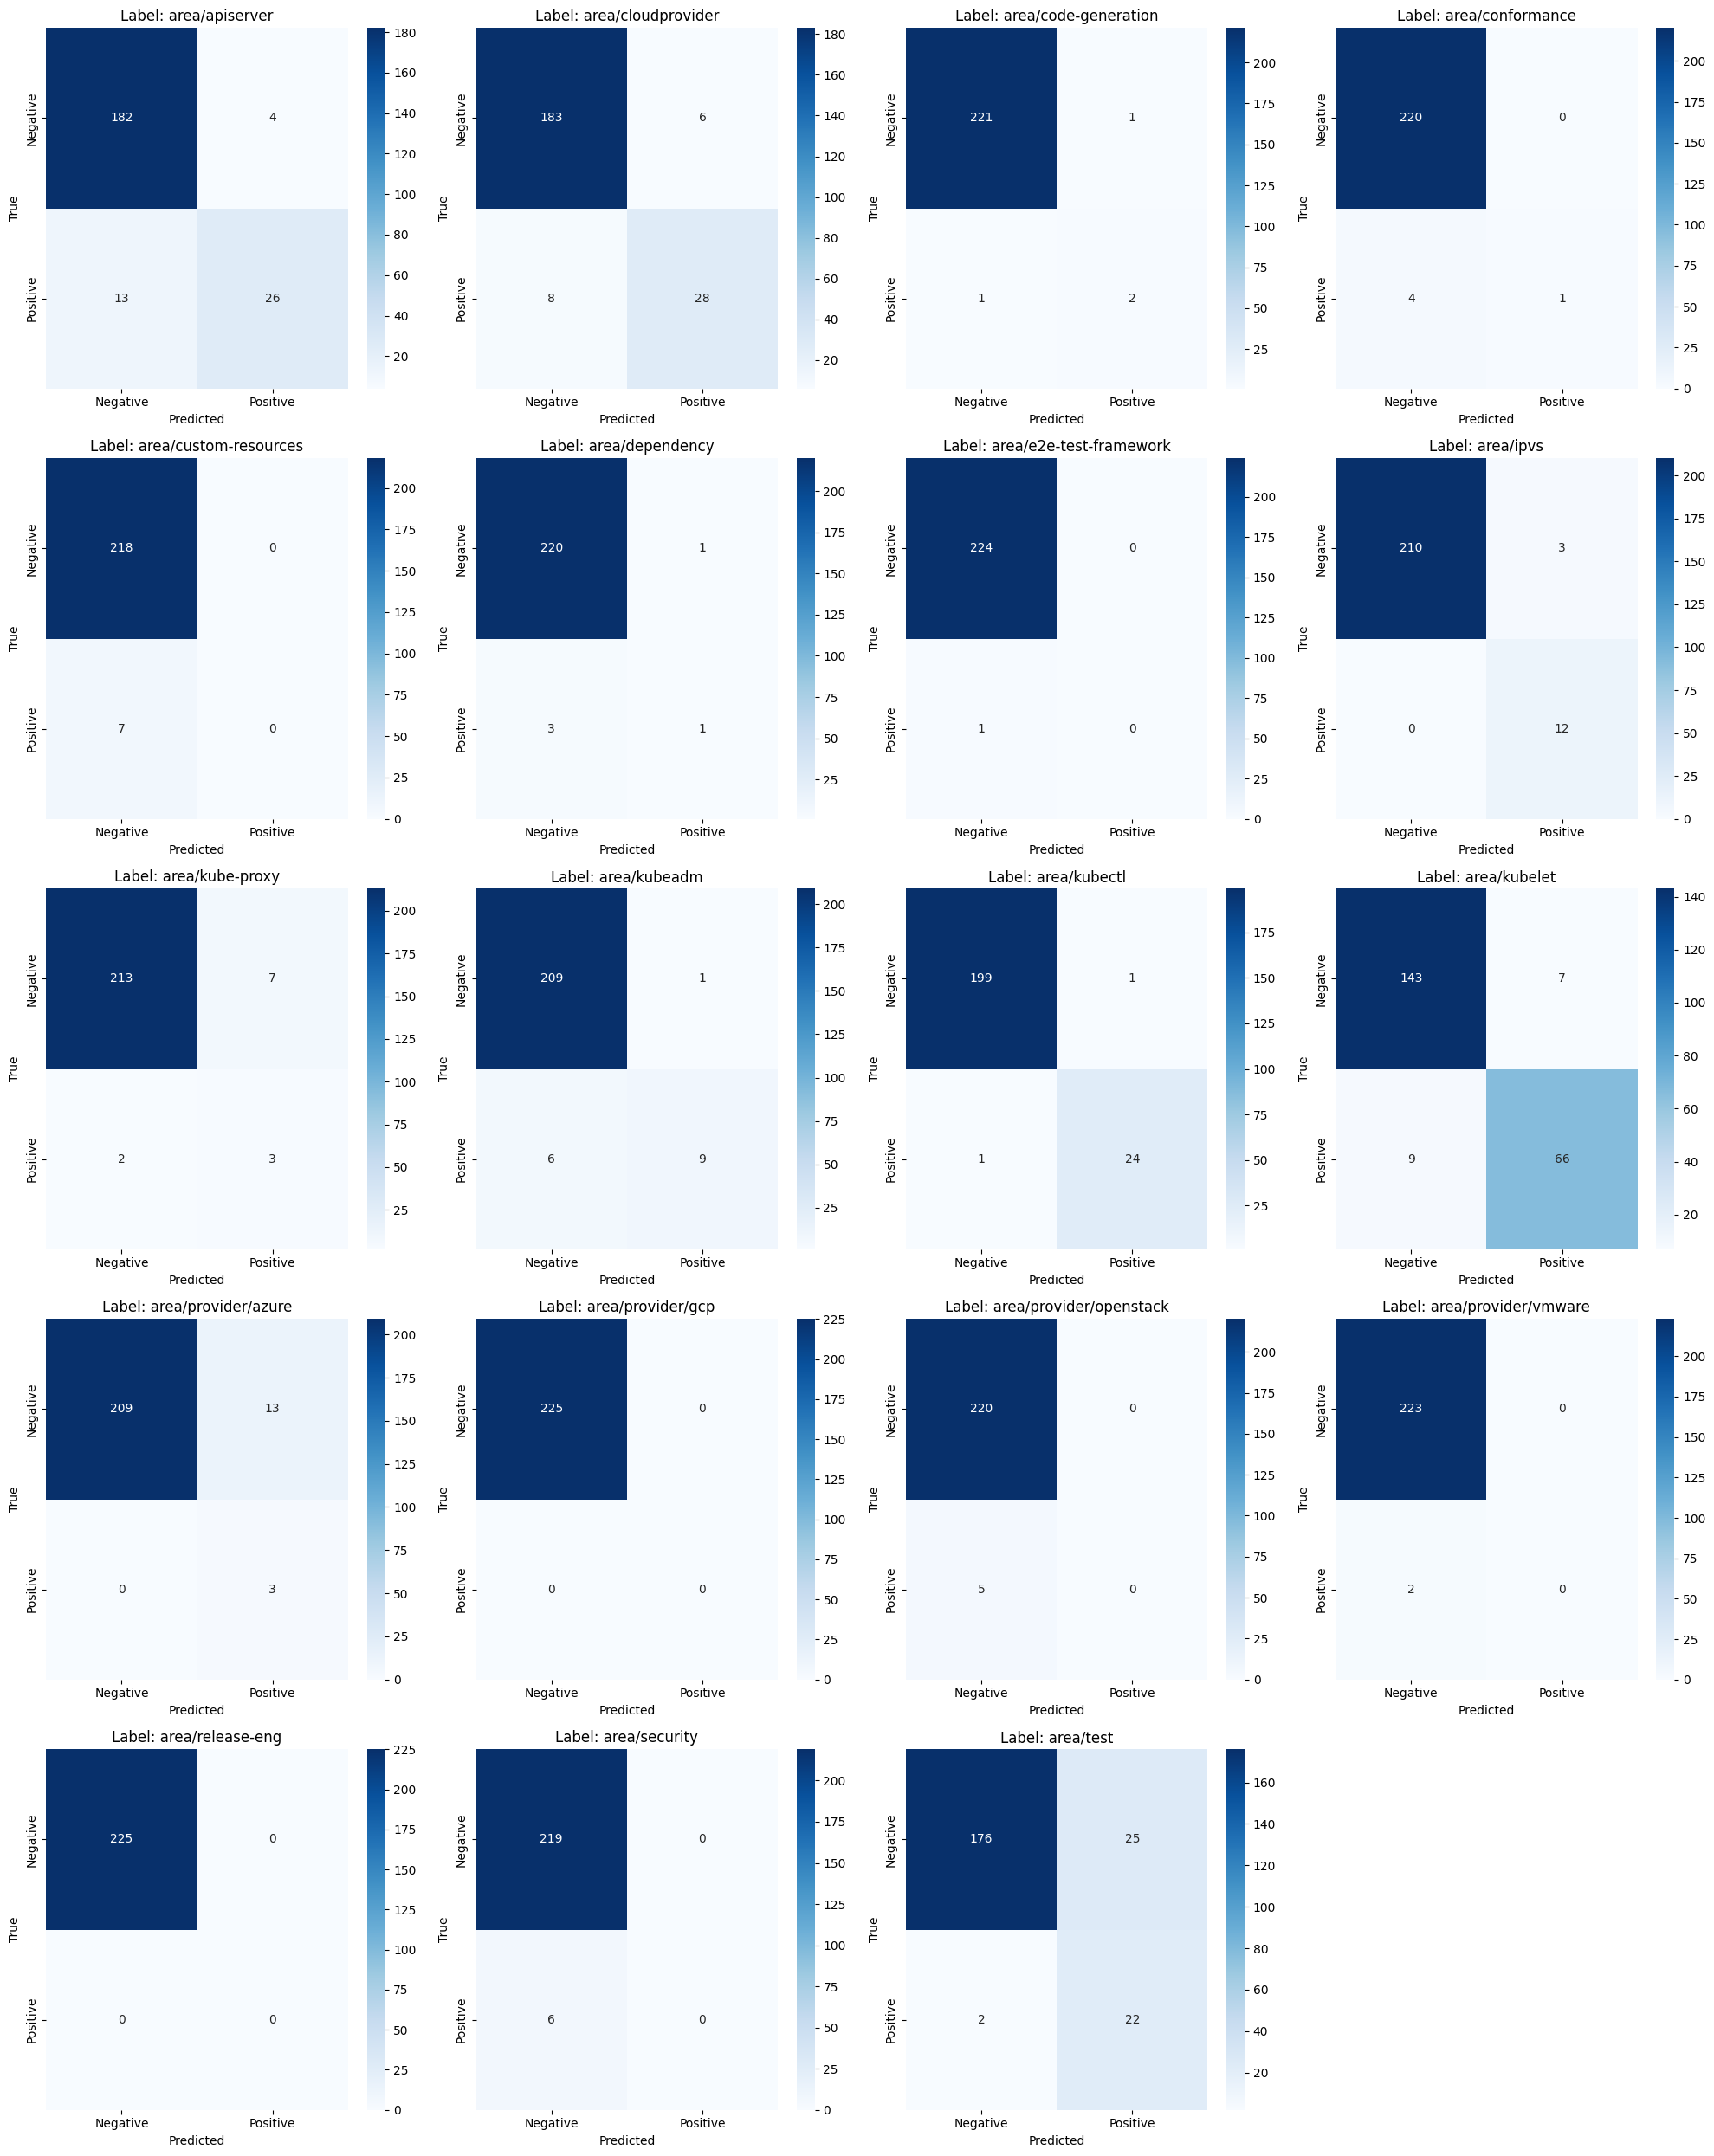

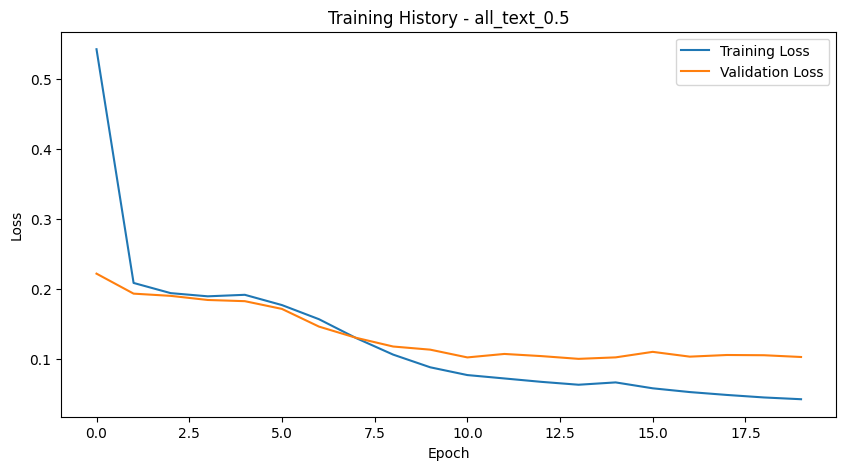

In [4]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=3,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:03<00:00, 383.94it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples by std dev filtering (1.67% of data)
Total removed: 21 samples (1.67% of original data)
Remaining: 1237 samples (98.33% of original data)

Token length statistics after all filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1222 (98.79% of data)

St

Calculating token lengths: 100%|██████████| 1098/1098 [00:02<00:00, 546.51it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1693
Mean token length: 307.34
Median token length: 224.50
Encoding labels...
Label density: 0.0636
Average labels per sample: 1.21
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 878, Validation samples: 220
Loading tokenizer...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Train Loss: 0.5559, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2320
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


Train Loss: 0.2064, Train Accuracy (Exact Match): 0.0023
Val Loss: 0.1958
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.1914, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.1938
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


Train Loss: 0.1867, Train Accuracy (Exact Match): 0.0023
Val Loss: 0.1908
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.1815, Train Accuracy (Exact Match): 0.0137
Val Loss: 0.1845
Val Accuracy (Exact Match): 0.1045
Val Accuracy (Partial Match): 0.1091
Val Accuracy (Jaccard): 0.1091
Val Precision: 0.1136, Val Recall: 0.1091, Val F1: 0.1106
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.1703, Train Accuracy (Exact Match): 0.0991
Val Loss: 0.1680
Val Accuracy (Exact Match): 0.1318
Val Accuracy (Partial Match): 0.1795
Val Accuracy (Jaccard): 0.1591
Val Precision: 0.1659, Val Recall: 0.1795, Val F1: 0.1682
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.1414, Train Accuracy (Exact Match): 0.3132
Val Loss: 0.1436
Val Accuracy (Exact Match): 0.3045
Val Accuracy (Partial Match): 0.3977
Val Accuracy (Jaccard): 0.3659
Val Precision: 0.3955, Val Recall: 0.3977, Val F1: 0.3864
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.1132, Train Accuracy (Exact Match): 0.4818
Val Loss: 0.1278
Val Accuracy (Exact Match): 0.4500
Val Accuracy (Partial Match): 0.5545
Val Accuracy (Jaccard): 0.5174
Val Precision: 0.5477, Val Recall: 0.5545, Val F1: 0.5409
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0909, Train Accuracy (Exact Match): 0.6310
Val Loss: 0.1191
Val Accuracy (Exact Match): 0.5318
Val Accuracy (Partial Match): 0.6477
Val Accuracy (Jaccard): 0.6076
Val Precision: 0.6432, Val Recall: 0.6477, Val F1: 0.6341
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0788, Train Accuracy (Exact Match): 0.6913
Val Loss: 0.1151
Val Accuracy (Exact Match): 0.5500
Val Accuracy (Partial Match): 0.6864
Val Accuracy (Jaccard): 0.6371
Val Precision: 0.6750, Val Recall: 0.6864, Val F1: 0.6674
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0712, Train Accuracy (Exact Match): 0.7153
Val Loss: 0.1099
Val Accuracy (Exact Match): 0.5682
Val Accuracy (Partial Match): 0.7273
Val Accuracy (Jaccard): 0.6682
Val Precision: 0.7091, Val Recall: 0.7273, Val F1: 0.7023
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0645, Train Accuracy (Exact Match): 0.7551
Val Loss: 0.1082
Val Accuracy (Exact Match): 0.5864
Val Accuracy (Partial Match): 0.7500
Val Accuracy (Jaccard): 0.6856
Val Precision: 0.7205, Val Recall: 0.7500, Val F1: 0.7197
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0600, Train Accuracy (Exact Match): 0.7563
Val Loss: 0.1080
Val Accuracy (Exact Match): 0.5636
Val Accuracy (Partial Match): 0.7523
Val Accuracy (Jaccard): 0.6788
Val Precision: 0.7205, Val Recall: 0.7523, Val F1: 0.7174

Epoch 14/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0560, Train Accuracy (Exact Match): 0.7654
Val Loss: 0.1060
Val Accuracy (Exact Match): 0.5727
Val Accuracy (Partial Match): 0.7591
Val Accuracy (Jaccard): 0.6871
Val Precision: 0.7295, Val Recall: 0.7591, Val F1: 0.7258
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0525, Train Accuracy (Exact Match): 0.7836
Val Loss: 0.1027
Val Accuracy (Exact Match): 0.5727
Val Accuracy (Partial Match): 0.7750
Val Accuracy (Jaccard): 0.6955
Val Precision: 0.7386, Val Recall: 0.7750, Val F1: 0.7364
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0492, Train Accuracy (Exact Match): 0.7859
Val Loss: 0.1022
Val Accuracy (Exact Match): 0.5955
Val Accuracy (Partial Match): 0.7659
Val Accuracy (Jaccard): 0.7015
Val Precision: 0.7432, Val Recall: 0.7659, Val F1: 0.7371
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Train Loss: 0.0454, Train Accuracy (Exact Match): 0.8041
Val Loss: 0.1037
Val Accuracy (Exact Match): 0.6000
Val Accuracy (Partial Match): 0.7773
Val Accuracy (Jaccard): 0.7045
Val Precision: 0.7364, Val Recall: 0.7773, Val F1: 0.7402
Saved new best model to ./results/run_20250411_111047_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Early stopping triggered
Train Loss: 0.0427, Train Accuracy (Exact Match): 0.8246
Val Loss: 0.1046
Val Accuracy (Exact Match): 0.5818
Val Accuracy (Partial Match): 0.7773
Val Accuracy (Jaccard): 0.6992
Val Precision: 0.7386, Val Recall: 0.7773, Val F1: 0.7386
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_18/3177817570.py:1302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.6000
Partial Match Accuracy: 0.7773
Jaccard Similarity: 0.7045
Precision: 0.7364
Recall: 0.7773
F1 Score: 0.7402

Training completed! Results saved to ./results/run_20250411_111047_all_text_0.5


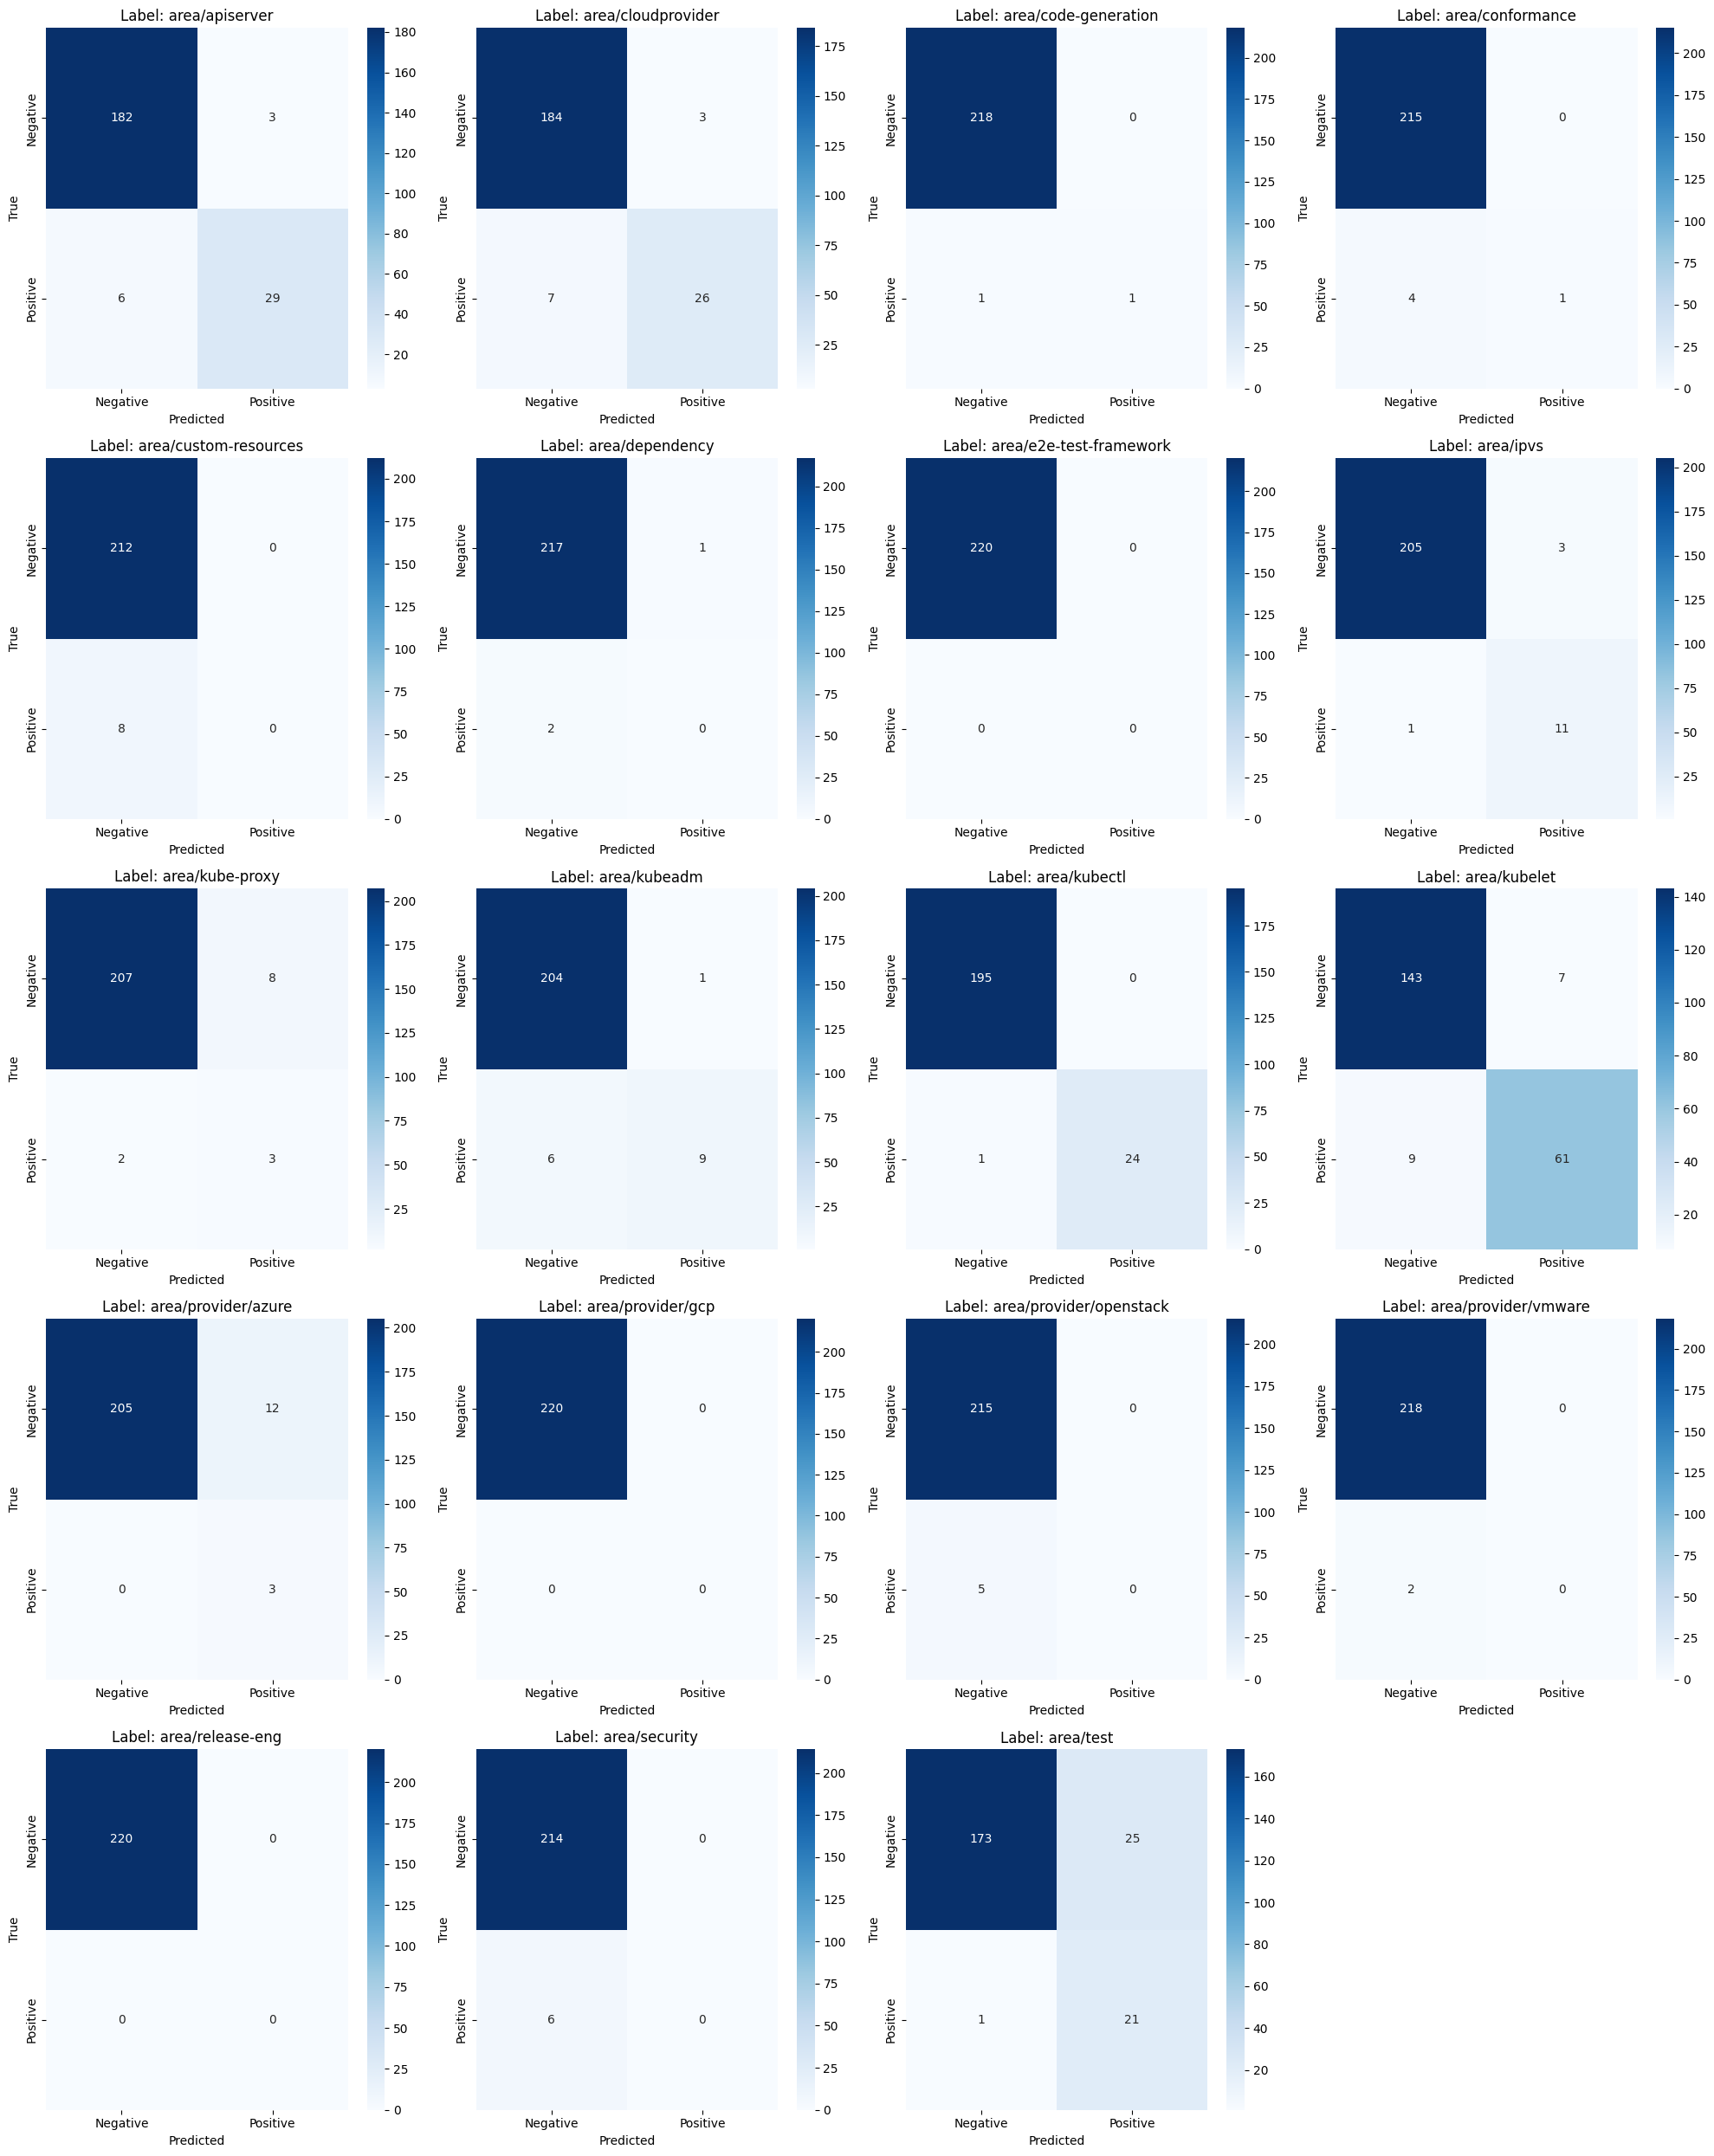

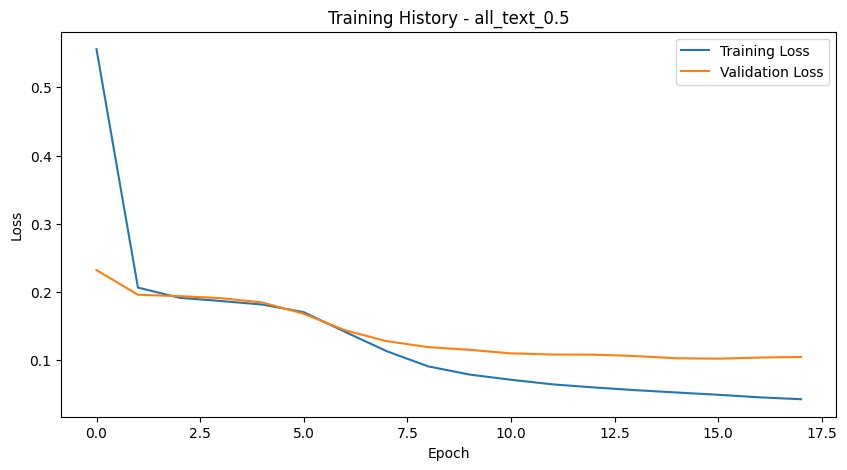

In [5]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:03<00:00, 382.56it/s]


Token length statistics before filtering:
  Mean: 379.62, Std Dev: 458.90
  Min: 32, Max: 5493
  25th percentile: 148.00
  50th percentile (median): 245.00
  75th percentile: 439.75
Applied 3.0 std dev threshold: (1.00, 1756.33)
Removed 21 samples by std dev filtering (1.67% of data)
Total removed: 21 samples (1.67% of original data)
Remaining: 1237 samples (98.33% of original data)

Token length statistics after all filtering:
  Mean: 336.26, Std Dev: 279.70
  Min: 32, Max: 1725
  25th percentile: 148.00
  50th percentile (median): 241.00
  75th percentile: 418.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1237
Dataset size after basic cleaning: 1237 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1222 (98.79% of data)

St

Calculating token lengths: 100%|██████████| 870/870 [00:01<00:00, 574.89it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 1693
Mean token length: 285.00
Median token length: 209.00
Encoding labels...
Label density: 0.0588
Average labels per sample: 1.00
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 696, Validation samples: 174
Loading tokenizer...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Train Loss: 0.6355, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2506
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250411_112526_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 22/22 [00:31<00:00,  1.43s/it]


Train Loss: 0.2141, Train Accuracy (Exact Match): 0.0072
Val Loss: 0.1907
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


Train Loss: 0.1845, Train Accuracy (Exact Match): 0.0057
Val Loss: 0.1924
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Train Loss: 0.1797, Train Accuracy (Exact Match): 0.0072
Val Loss: 0.1889
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 22/22 [00:30<00:00,  1.41s/it]


Train Loss: 0.1783, Train Accuracy (Exact Match): 0.0101
Val Loss: 0.1885
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Early stopping triggered
Train Loss: 0.1761, Train Accuracy (Exact Match): 0.0230
Val Loss: 0.1860
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Early stopping triggered. Terminating training.

Loading best model for final evaluation...


/tmp/ipykernel_18/3177817570.py:1302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.0000
Partial Match Accuracy: 0.0000
Jaccard Similarity: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Training completed! Results saved to ./results/run_20250411_112526_all_text_0.5


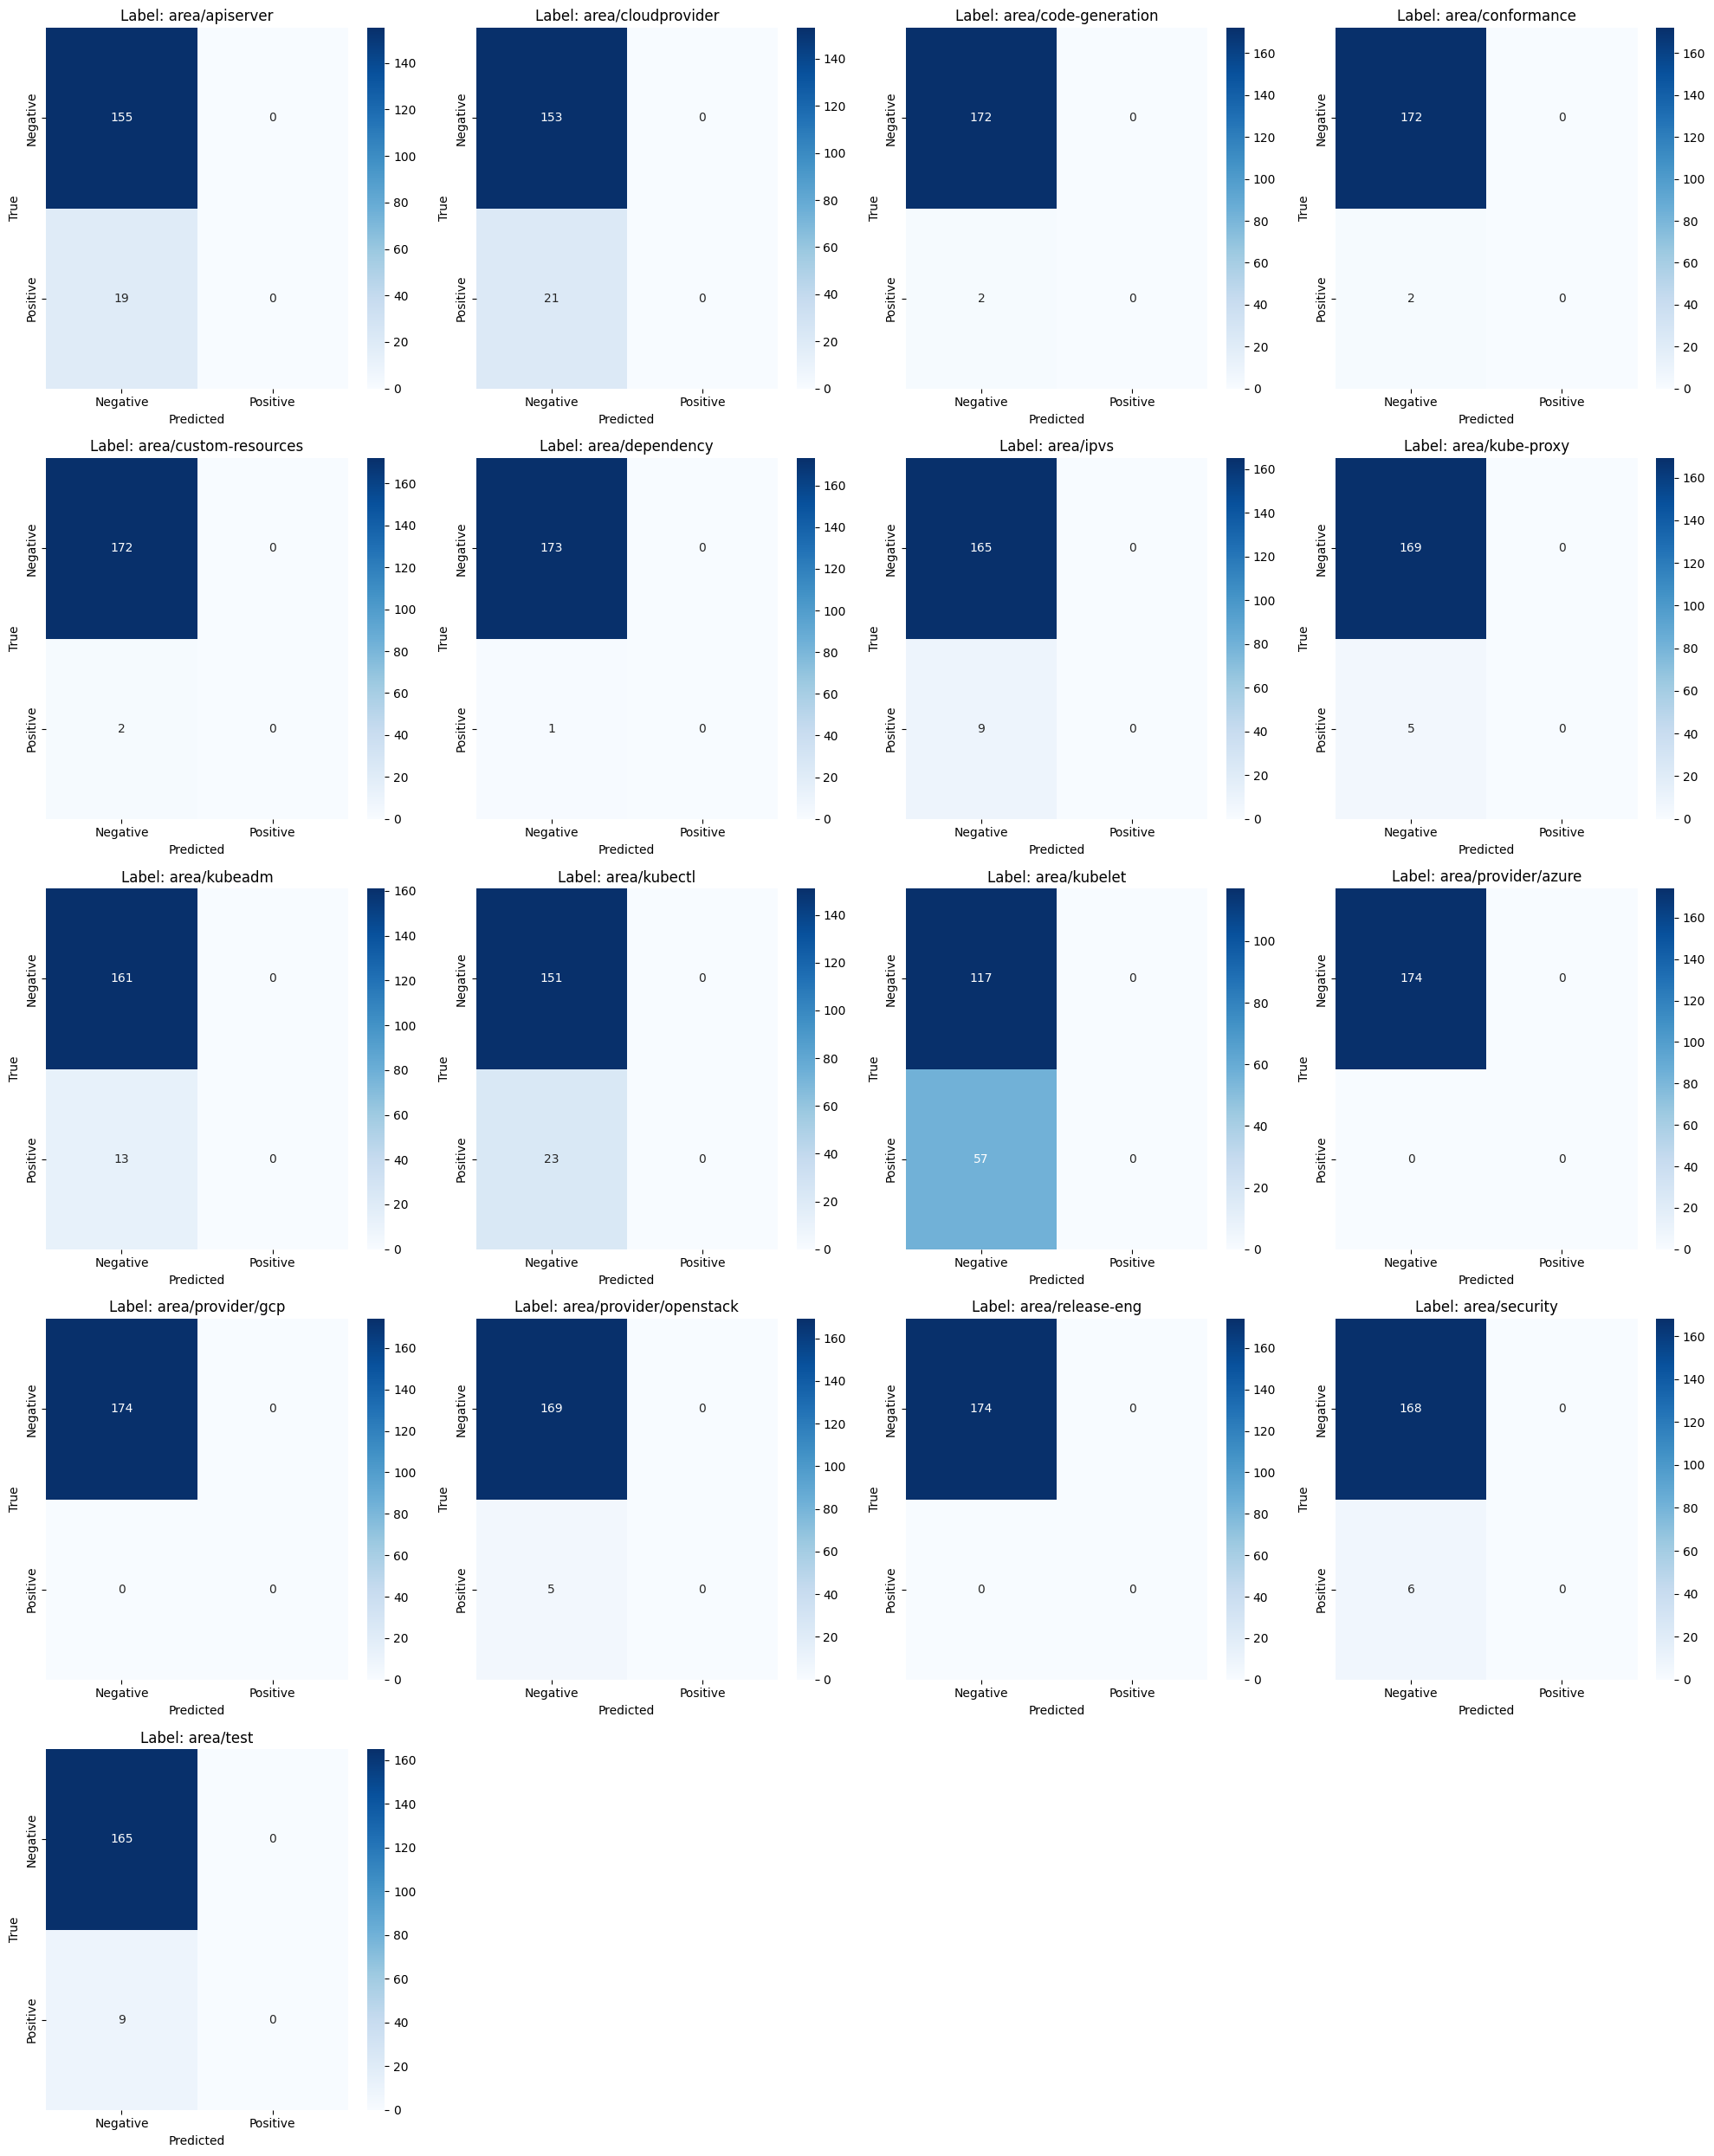

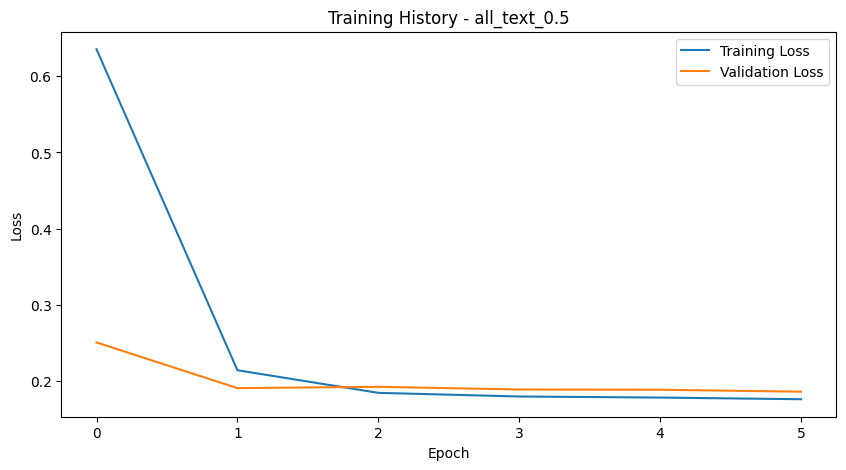

In [6]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=1,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)